<h1> Coursera IBM Capstone Project </h1>

<h3> Correlation between CIty Quality of Life and Surrounding Venues </h3>

<h2> Introduction </h2>

<h4> Business Problem </h4>
A client who runs a sunccessful business, has asked for us to identify cities where their business could be equally successful.
In this project we will try to find similar cities to a selected city ('Auckland' in New Zealand) - which is where the clients business is located.

To identify possible cities, we will base this decision based on the correlation between the City Quality of Life Index and compare similar cities based on location data from FourSquare.
The quality of life index will give a glimpse into the general sentiment of our clients customers, while the FourSquare location data will provide insight into the typical city venue make-up.

<h4> Target Audience </h4>
The target audience is a client looking to identify new expansion options around the world.
They will have an idea of a current city where their business is currently successful.


<h2> Data </h2>

Based on our problem, we have identified an external data source that contains various quality of life indicies. In addition, FourSquare data will be used to identify cities with similar surrounding venues.

The following data sources will be used:
<li> City Quality of Life Dataset (from Teleport.org) </li>
<li> FourSquare location data, and venue information </li>

We will use the Quality of Life dataset identify similar rated cities (through the use of DBSCAN CLustering).

Next we will use FourSquare venue data from the city centre - which will be used to identify the most similar cities from the quality of life cluster.

<h4> City Quality of Life Dataset </h4>
The quality of life is identified by several unique scores (housing, cost of living, startups, venture capital, travel connectivity, commute, business freedom, safety, healthcare, education, environmental quality, economy, taxation and internet access). By taking an average of the following scores:
<li> Cost of living </li>
<li> Startups </li>
<li> Travel Connectivity </li>
<li> Business Freedom </li>
<li> Economy </li>
<li> Taxation </li>
Using the above indicies, a clustering technique (DBSCAN) will be used to identify cities similar to the clients input option.

<h4> FourSquare Data </h4>
The FourSquare data will be used to identify the top options from the identified Quality of Life city.
This will also be selected using an un-supervised classification method (k-means).

<h4> Example Data </h4>
The Quality of Life Dataset could identify cities whose residents value similar lifestyle qualities.

Following this, we will have a list of cities that we can then compare based on similar popular venue types.

<h2> Analysis </h2>

In [5]:
#  System Imports:
#  none
import csv
import json

#  Typical Imports:
#!pip install pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import preprocessing

#  Third Party Imports:
#  none

<h3> Get Quality of Life Dataset: </h3>

In [9]:
# The code was removed by Watson Studio for sharing.

,Unnamed: 0,UA_Name,UA_Country,UA_Continent,Housing,Cost of Living,Startups,Venture Capital,Travel Connectivity,Commute,...,Safety,Healthcare,Education,Environmental Quality,Economy,Taxation,Internet Access,Leisure & Culture,Tolerance,Outdoors
0,0,Aarhus,Denmark,Europe,6.1315,4.015,2.8270,2.512,3.5360,6.31175,...,9.6165,8.704333,5.3665,7.63300,4.8865,5.0680,8.373,3.1870,9.7385,4.1300
1,1,Adelaide,Australia,Oceania,6.3095,4.692,3.1365,2.640,1.7765,5.33625,...,7.9260,7.936667,5.1420,8.33075,6.0695,4.5885,4.341,4.3285,7.8220,5.5310
2,2,Albuquerque,New Mexico,North America,7.2620,6.059,3.7720,1.493,1.4555,5.05575,...,1.3435,6.430000,4.1520,7.31950,6.5145,4.3460,5.396,4.8900,7.0285,3.5155
3,3,Almaty,Kazakhstan,Asia,9.2820,9.333,2.4585,0.000,4.5920,5.87125,...,7.3090,4.545667,2.2830,3.85675,5.2690,8.5220,2.886,2.9370,6.5395,5.5000
4,4,Amsterdam,Netherlands,Europe,3.0530,3.824,7.9715,6.107,8.3245,6.11850,...,8.5035,7.907333,6.1800,7.59725,5.0530,4.9550,4.523,8.8740,8.3680,5.3070


In [10]:
#  Only keep columns of interest:
quality_of_life_db = quality_of_life_db[['UA_Name','UA_Country',
                                         'Cost of Living', 'Venture Capital',
                                         'Travel Connectivity','Business Freedom',
                                         'Economy','Taxation', 'Leisure & Culture']]

quality_of_life_db.head()

,UA_Name,UA_Country,Cost of Living,Venture Capital,Travel Connectivity,Business Freedom,Economy,Taxation,Leisure & Culture
0,Aarhus,Denmark,4.015,2.512,3.5360,9.940000,4.8865,5.0680,3.1870
1,Adelaide,Australia,4.692,2.640,1.7765,9.399667,6.0695,4.5885,4.3285
2,Albuquerque,New Mexico,6.059,1.493,1.4555,8.671000,6.5145,4.3460,4.8900
3,Almaty,Kazakhstan,9.333,0.000,4.5920,5.568000,5.2690,8.5220,2.9370
4,Amsterdam,Netherlands,3.824,6.107,8.3245,8.836667,5.0530,4.9550,8.8740


In [11]:
#  We will standardise the values and then use DBSCAN to find similar cities to our target (Auckland)
#  Note: we will do this before train/test split for ease of data handling.

city_index = quality_of_life_db[quality_of_life_db['UA_Name'] == 'Auckland'].index

qol_features = quality_of_life_db[['Cost of Living', 'Venture Capital',
                                   'Travel Connectivity','Business Freedom',
                                   'Economy','Taxation', 'Leisure & Culture']]
X_qol = qol_features
X_qol_normalised = preprocessing.StandardScaler().fit(X_qol)
X_qol = X_qol_normalised.transform(X_qol)

<h3> DBSCAN of Cities </h3>

Prepare Quality of Life data and use DBSCAN method to cluster these into groups.
We will then use the cities of the same cluster as our selected city in futher investigations.

In [12]:
#  Imports Required:
from sklearn.cluster import DBSCAN

#  Get Clusters:
epsilon = 1.1
minimumSamples = 4
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X_qol)
labels = db.labels_

<h4> Distinguish Outliers: </h4>

In [13]:
# Firts, create an array of booleans using the labels from db.
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print("Number of clusters is:" ,n_clusters_)
print("Auckland cluster is:", labels[city_index])
# Remove repetition in labels by turning it into a set.
unique_labels = set(labels)

Number of clusters is: 7
Auckland cluster is: [0]


<h4> Organise Visualisation </h4>

Showing a visualisation of the data will not provide a huge insight into this data-set due to the number of dimensions.
However, we can show an example of a comparison between 2 columns.

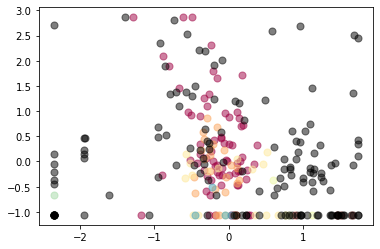

In [14]:
# Create colors for the clusters.
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

# Plot the points with colors
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    # Plot the datapoints that are clustered
    xy = X_qol[class_member_mask & core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

    # Plot the outliers
    xy = X_qol[class_member_mask & ~core_samples_mask]
    plt.scatter(xy[:, 0], xy[:, 1],s=50, c=[col], marker=u'o', alpha=0.5)

<h4> Sort Similar Cities </h4>

In [15]:
label_mask = (labels == labels[city_index])
similar_cities = quality_of_life_db[label_mask]
print("There are ",len(similar_cities), " similar cities identified.")

print("The selected City QOL indicators are:")
selected_city = quality_of_life_db.iloc[city_index]
selected_city

There are  71  similar cities identified.
The selected City QOL indicators are:


,UA_Name,UA_Country,Cost of Living,Venture Capital,Travel Connectivity,Business Freedom,Economy,Taxation,Leisure & Culture
12,Auckland,New Zealand,4.47,2.79,1.3045,10.0,5.5055,5.9315,4.396


In [16]:
#  Now we will rank the similar cities based on the mean square error for the identified QOL indicators:
indicators = ['Cost of Living', 'Venture Capital',
              'Travel Connectivity', 'Business Freedom',
             'Economy', 'Taxation', 'Leisure & Culture']

mse_difference = np.zeros(len(similar_cities))

for indicator in indicators:
    mse_difference = mse_difference + np.power((similar_cities[indicator].values - selected_city[indicator].values),2)
    
similar_cities.insert(2,'MSE',mse_difference)

In [17]:
similar_cities = similar_cities.sort_values(by='MSE')
similar_cities.head(10)

,UA_Name,UA_Country,MSE,Cost of Living,Venture Capital,Travel Connectivity,Business Freedom,Economy,Taxation,Leisure & Culture
12,Auckland,New Zealand,0.000000,4.470,2.790,1.3045,10.000000,5.5055,5.9315,4.3960
260,Wellington,New Zealand,1.798363,5.161,1.753,0.8525,10.000000,5.5055,5.9315,4.5990
1,Adelaide,Australia,2.781269,4.692,2.640,1.7765,9.399667,6.0695,4.5885,4.3285
185,Perth,Australia,3.348090,4.795,3.102,2.1105,9.399667,6.0695,4.5885,4.5115
101,Halifax,Canada,3.741401,4.943,2.284,1.5700,8.966000,5.8405,7.2745,3.9420
255,Victoria,Canada,4.562589,5.703,2.719,1.4945,8.966000,5.8405,7.2745,4.5230
40,Brisbane,Australia,4.610390,5.177,3.240,2.4345,9.399667,6.0695,4.5885,4.0100
84,Edmonton,Canada,4.785228,5.522,2.392,1.9020,8.966000,5.8405,7.2745,3.9740
49,Calgary,Canada,5.931524,5.418,2.036,2.5140,8.966000,5.8405,7.2745,4.2680
114,Jacksonville,Florida,6.632099,5.359,2.545,1.5675,8.671000,6.5145,4.7720,5.6545


<h3> Get City Centre Latitude/Longitude: </h3>

We will need to get the city centre locations to use with the FourSquare API.

In [18]:
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [19]:
def get_location(city, country):
    address = city + ", " + country

    geolocator = Nominatim(user_agent="city_locations")
    location = geolocator.geocode(address)
    return location

In [20]:
latitude = []
longitude = []

#  lets consider top 20 Cities (incl. Auackland)
similar_cities_top = similar_cities.head(20)

for index, similar_city in similar_cities_top.iterrows():
    location = get_location(similar_city['UA_Name'],
                           similar_city['UA_Country'])
    if location != None:
        lat = location.latitude
        lon = location.longitude
        latitude.append(lat)
        longitude.append(lon)

similar_cities = similar_cities_top[['UA_Name', 'UA_Country']]
similar_cities.insert(len(similar_cities.columns),'Latitude',latitude)
similar_cities.insert(len(similar_cities.columns),'Longitude',longitude)

In [21]:
similar_cities.head()

,UA_Name,UA_Country,Latitude,Longitude
12,Auckland,New Zealand,-36.852095,174.763180
260,Wellington,New Zealand,-41.288795,174.777211
1,Adelaide,Australia,-34.928181,138.599931
185,Perth,Australia,-31.952712,115.860480
101,Halifax,Canada,44.648618,-63.585949


<h3> Use FourSquare API </h3>

<h4> Set FourSquare Credentials </h4>

The following cell is hidden as it is private account information.

In [22]:
# The code was removed by Watson Studio for sharing.

Start to pull out venue data from FourSquare

In [23]:
import requests

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    #  Function that takes city names, latitudes and longitudes and outputs venues of interest.
    #  It is assumed the lat/lon inputs are city centres.
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
#  Get surrounding venues for each similar city:
similar_city_venues = getNearbyVenues(names=similar_cities['UA_Name'],
                                   latitudes=similar_cities['Latitude'],
                                   longitudes=similar_cities['Longitude']
                                  )

<h4> Find all the different types of venues found: </h4>

In [25]:
print('There are {} uniques categories.'.format(len(similar_city_venues['Venue Category'].unique())))

There are 156 uniques categories.


<h4> Investigate Each City </h4>

We will use one-hot encoding to facilitate the comparison of cities.

This is simply a transformation of the data into a true/false (1/0) dataframe.

In [26]:
# one hot encoding
similar_cities_onehot = pd.get_dummies(similar_city_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
similar_cities_onehot.insert(0,'City',similar_city_venues['City'] )

similar_cities_onehot.head()

,City,American Restaurant,Antique Shop,Arcade,Art Gallery,Asian Restaurant,Australian Restaurant,Bagel Shop,Bakery,Bar,...,Theater,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop
0,Auckland,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Auckland,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Auckland,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Auckland,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Auckland,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
similar_cities_grouped = similar_cities_onehot.groupby('City').mean().reset_index()
similar_cities_grouped.head()

,City,American Restaurant,Antique Shop,Arcade,Art Gallery,Asian Restaurant,Australian Restaurant,Bagel Shop,Bakery,Bar,...,Theater,Trattoria/Osteria,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop
0,Adelaide,0.000000,0.000000,0.0,0.000000,0.066667,0.033333,0.000000,0.000000,0.033333,...,0.033333,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.066667,0.0
1,Albuquerque,0.000000,0.000000,0.0,0.000000,0.033333,0.000000,0.000000,0.000000,0.100000,...,0.066667,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,Auckland,0.000000,0.000000,0.0,0.033333,0.000000,0.000000,0.033333,0.033333,0.000000,...,0.100000,0.0,0.033333,0.033333,0.0,0.0,0.0,0.0,0.000000,0.0
3,Birmingham,0.083333,0.041667,0.0,0.000000,0.083333,0.000000,0.000000,0.000000,0.125000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,Brisbane,0.000000,0.000000,0.0,0.000000,0.000000,0.033333,0.000000,0.000000,0.033333,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


Determine the most common venues in each city by counting the occurance of each venue type.

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
similar_city_venues_sorted = pd.DataFrame(columns=columns)
similar_city_venues_sorted['City'] = similar_cities_grouped['City']

for ind in np.arange(similar_cities_grouped.shape[0]):
    similar_city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(similar_cities_grouped.iloc[ind, :], num_top_venues)

similar_city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Café,Wine Bar,Asian Restaurant,Sushi Restaurant,Pizza Place,Park,Cheese Shop,Cocktail Bar,Pub,Coffee Shop
1,Albuquerque,Bar,Coffee Shop,Brewery,Theater,Ice Cream Shop,Music Venue,Restaurant,Hotel Bar,Plaza,Pizza Place
2,Auckland,Theater,Japanese Restaurant,Steakhouse,Coffee Shop,Bubble Tea Shop,Burger Joint,Restaurant,Record Shop,Plaza,City Hall
3,Birmingham,Bar,American Restaurant,Asian Restaurant,Southern / Soul Food Restaurant,Gym,Moving Target,Mexican Restaurant,Lounge,Insurance Office,Home Service
4,Brisbane,Café,Coffee Shop,Hotel,Japanese Restaurant,Juice Bar,Korean Restaurant,Frozen Yogurt Shop,French Restaurant,Mexican Restaurant,Burger Joint


<h3> Cluster Similar Cities Based on Venues Surrounding City Centre </h3>

Use k-means method of clustering to identify similar cities based on thier surrounding venues.

In [30]:
from sklearn.cluster import KMeans

#  set number of clusters
kclusters = 5

similar_cities_clustering = similar_cities_grouped.drop('City', 1)

#  run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(similar_cities_clustering)

#  check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 0, 1, 3, 1, 1, 1], dtype=int32)

Create a new dataframe that includes cluster AND top venues.

In [31]:
#  add clustering labels
similar_city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
similar_city_venues_sorted['Cluster Labels'].astype(int)

similar_cities_merged = similar_cities
#  Merge similar cities data with the cluster labels.
similar_cities_merged = similar_cities_merged.join(similar_city_venues_sorted.set_index('City'), on='UA_Name')

similar_cities_merged.head()

,UA_Name,UA_Country,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Auckland,New Zealand,-36.852095,174.763180,1.0,Theater,Japanese Restaurant,Steakhouse,Coffee Shop,Bubble Tea Shop,Burger Joint,Restaurant,Record Shop,Plaza,City Hall
260,Wellington,New Zealand,-41.288795,174.777211,1.0,Café,Coffee Shop,Bar,Restaurant,Exhibit,Bridge,Camera Store,Chinese Restaurant,Concert Hall,Gastropub
1,Adelaide,Australia,-34.928181,138.599931,0.0,Café,Wine Bar,Asian Restaurant,Sushi Restaurant,Pizza Place,Park,Cheese Shop,Cocktail Bar,Pub,Coffee Shop
185,Perth,Australia,-31.952712,115.860480,1.0,Coffee Shop,Sushi Restaurant,Korean Restaurant,Hotel,Vietnamese Restaurant,Gastropub,Dessert Shop,Pizza Place,Clothing Store,Plaza
101,Halifax,Canada,44.648618,-63.585949,2.0,American Restaurant,Brewery,Skating Rink,Rock Club,Rock Climbing Spot,Restaurant,Performing Arts Venue,Gym / Fitness Center,Paper / Office Supplies Store,Outdoors & Recreation


In [32]:
similar_cities_merged.dropna(inplace=True)
similar_cities_merged['Cluster Labels'] = similar_cities_merged['Cluster Labels'].astype(int)
similar_cities_merged.dtypes

UA_Name                    object
UA_Country                 object
Latitude                  float64
Longitude                 float64
Cluster Labels              int64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

<h2> Visualise Data Using Folium (World Map) </h2>

We will use the Folium package to show the various clusters around the world.

In [35]:
#!pip install folium
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [36]:
# create map
map_clusters = folium.Map()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = plt.cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(similar_cities_merged['Latitude'], similar_cities_merged['Longitude'], 
                                  similar_cities_merged['UA_Name'], similar_cities_merged['Cluster Labels']):
    
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<h3> Show all cities from Selected City Cluster </h3>

In [37]:
selected_city_cluster = similar_cities_merged[similar_cities_merged['UA_Name'] == 'Auckland']['Cluster Labels'].values[0]

In [38]:
similar_cities_merged.loc[similar_cities_merged['Cluster Labels'] == selected_city_cluster, 
                          similar_cities_merged.columns[[0,1] + list(range(5, similar_cities_merged.shape[1]))]]

,UA_Name,UA_Country,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Auckland,New Zealand,Theater,Japanese Restaurant,Steakhouse,Coffee Shop,Bubble Tea Shop,Burger Joint,Restaurant,Record Shop,Plaza,City Hall
260,Wellington,New Zealand,Café,Coffee Shop,Bar,Restaurant,Exhibit,Bridge,Camera Store,Chinese Restaurant,Concert Hall,Gastropub
185,Perth,Australia,Coffee Shop,Sushi Restaurant,Korean Restaurant,Hotel,Vietnamese Restaurant,Gastropub,Dessert Shop,Pizza Place,Clothing Store,Plaza
67,Colorado Springs,Colorado,Coffee Shop,Hotel,Mexican Restaurant,Steakhouse,Sandwich Place,Ice Cream Shop,New American Restaurant,Mediterranean Restaurant,Juice Bar,Italian Restaurant
57,Chattanooga,Tennessee,Bar,Coffee Shop,Music Venue,Hotel,Restaurant,American Restaurant,Sandwich Place,Smoke Shop,Southern / Soul Food Restaurant,Pizza Place
47,Buffalo,New York,Hotel,Coffee Shop,Pizza Place,Beer Bar,Event Space,Farmers Market,Scenic Lookout,Plaza,Cocktail Bar,Boutique
2,Albuquerque,New Mexico,Bar,Coffee Shop,Brewery,Theater,Ice Cream Shop,Music Venue,Restaurant,Hotel Bar,Plaza,Pizza Place
62,Christchurch,New Zealand,Bar,Hotel,Plaza,Burger Joint,Café,Cajun / Creole Restaurant,Restaurant,Chinese Restaurant,Pub,Playground
86,Eugene,Oregon,Coffee Shop,Concert Hall,Pizza Place,Breakfast Spot,Café,Chinese Restaurant,Performing Arts Venue,Dive Bar,Donut Shop,Farmers Market
30,Birmingham,Alabama,Bar,American Restaurant,Asian Restaurant,Southern / Soul Food Restaurant,Gym,Moving Target,Mexican Restaurant,Lounge,Insurance Office,Home Service


<h2> Results </h2>

Based on the investigation above, it appears that if the Client wishes to expand their business they should look locally first to Wellington. Then consider an expansion scheme into Autralia (Perth) and North America (Olorado, Tenessee, New York) or Canada (Ottawa).

We have intially used a quality of life dataset to identify similar cities to our clients input city (Auckland).
This was achieved using DBSCAN Unsupervised clustering technique. Following this, we used location and venue data provided by FourSquare to find the most similar city centres to identify the most similar cities.

<h2> Conclusion </h2>

The data used for this observation includes high-level quality of life indicies which have been used to narrow down cities world-wide that may have similar resident behaviours. Additionally, FourSquare data has been used to identify venues surrounding the city centre to further refine potential focus cities for expansion oppourtunities.

Ultimately the client should consider their preferred focus countries, then a targeted city investigation could be undertaken. This would delve deeper into city districts and could include further considerations.